In [1]:
import copy
import math
import random
import time
from pathlib import Path
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init
from IPython.display import Audio, display
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)

# Check for MPS (Apple Silicon GPU) first since we're on Mac
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU") 
else:
    device = torch.device("cpu")
    print("Using CPU")

device

Using CPU


device(type='cpu')

## Load the dataset
Data can be downloaded from http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

In [3]:
from helpers.utils import load_from_path

data_path = Path('data/speech_commands_v0.01')
train_, valid_, test_ = load_from_path(data_path)

print(f'training list has {len(train_)} elements')
print(f'testing list has {len(test_)} elements')
print(f'validation list has {len(valid_)} elements')

training list has 51088 elements
testing list has 6835 elements
validation list has 6798 elements


In [4]:
background_noise_list = []
for root, _, files in os.walk(data_path / '_background_noise_'):
    root_path = Path(root)
    for file in files:
        if not file.endswith('.wav'):
            continue
        data_entry = {
            'file_path': root_path / file,
            'label': file[:-4]
        }
        background_noise_list.append(data_entry)
print(f'background noise files: {[noise["label"] for noise in background_noise_list]}')

background noise files: ['running_tap', 'doing_the_dishes', 'pink_noise', 'exercise_bike', 'white_noise', 'dude_miaowing']


## Use dataset builder

In [5]:
from helpers.dataset_builder import DatasetBuilder

builder = DatasetBuilder(train_, valid_, test_, seed)
train, valid, test = builder \
    .keep_labels(['yes', 'no'], make_rest_unknown=False) \
    .build()

label2id = builder.label2id
id2label = builder.id2label

train: 3713  | {'yes': 1860, 'no': 1853}
  val:  531  | {'yes': 261, 'no': 270}
 test:  508  | {'yes': 256, 'no': 252}


### Data visualization – audio examples

no


yes


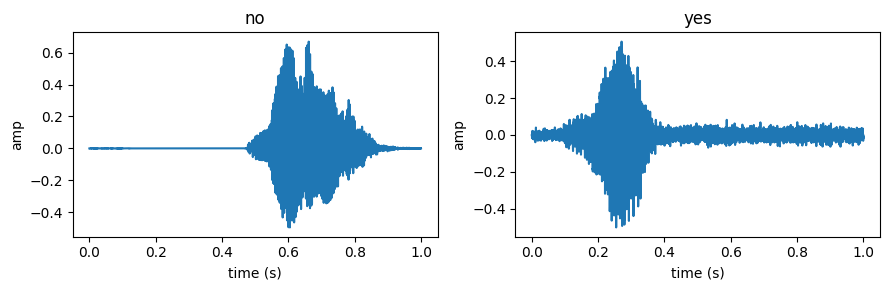

In [6]:
from helpers.utils import show_random_example_per_class

show_random_example_per_class(train, 2)

In [7]:
from helpers.utils import preprocess_dataset

X_train, y_train = preprocess_dataset(train, "train")
X_val,   y_val   = preprocess_dataset(valid, "valid")
X_test,  y_test  = preprocess_dataset(test,  "test")

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Pre-processing test: 100%|██████████| 508/508 [00:03<00:00, 132.67it/s]

Train shape: torch.Size([3713, 40, 101]) torch.Size([3713])
Validation shape: torch.Size([531, 40, 101]) torch.Size([531])
Test shape: torch.Size([508, 40, 101]) torch.Size([508])


## Models and training

In [8]:
batch_size = 64

train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val,   y_val)
test_ds  = TensorDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

print(f"{len(train_loader)=}, {len(val_loader)=}, {len(test_loader)=}")

len(train_loader)=58, len(val_loader)=9, len(test_loader)=8


### Baseline CNN

In [9]:
from helpers.utils import train_model, eval_model

In [10]:
from helpers.models import ConvBaseline

cnn_model  = ConvBaseline(len(id2label)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

epochs = 40
history, best_val = train_model(
    cnn_model,
    device,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler=scheduler,
    epochs=epochs,
)
print(f"Best val-accuracy: {best_val:.3%}")

[01/40] train 0.5290/0.760 – val 0.3583/0.878
[02/40] train 0.3545/0.872 – val 0.2483/0.936
[03/40] train 0.2701/0.916 – val 0.1862/0.944
[04/40] train 0.2246/0.932 – val 0.1585/0.951
[05/40] train 0.1898/0.940 – val 0.1397/0.960
[06/40] train 0.1691/0.949 – val 0.1302/0.962
[07/40] train 0.1543/0.954 – val 0.1349/0.944
[08/40] train 0.1407/0.956 – val 0.1144/0.959
[09/40] train 0.1386/0.956 – val 0.1043/0.964
[10/40] train 0.1369/0.958 – val 0.0927/0.970
[11/40] train 0.1232/0.960 – val 0.0946/0.972
[12/40] train 0.1224/0.960 – val 0.0842/0.972
[13/40] train 0.1131/0.964 – val 0.0850/0.976
[14/40] train 0.1176/0.964 – val 0.0882/0.968
[15/40] train 0.1104/0.966 – val 0.0794/0.974
[16/40] train 0.1083/0.964 – val 0.0792/0.974
⏹️  Early stopping after 16 epochs (no val-improve for 3 epochs).
Best val-accuracy: 97.552%


Test accuracy: 96.850%


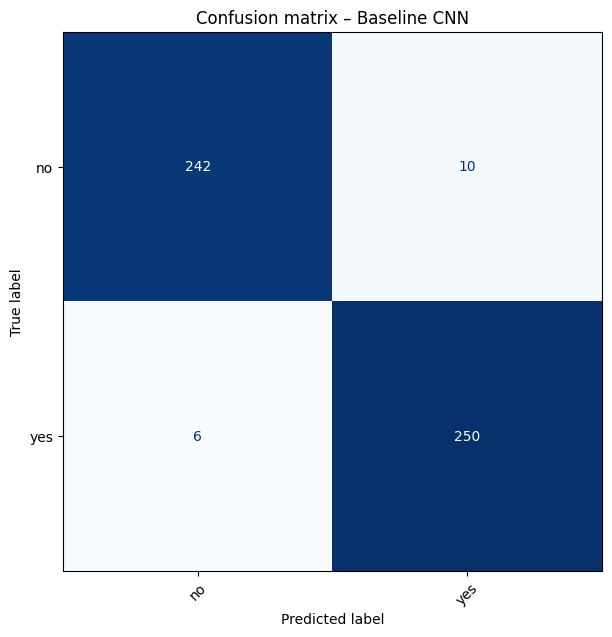

In [11]:
eval_model(device, cnn_model, test_loader, 'Baseline CNN', id2label)

### Transformer

In [12]:
from helpers.models import TransformerClassifier

tfm_model = TransformerClassifier(
    len(id2label),
    n_mfcc=40,
    d_model=128,
    n_heads=4,
    num_layers=4,
    dim_ff=256,
    dropout=0.1,
    pool="cls"             # or "mean"
).to(device)

criterion  = nn.CrossEntropyLoss()
optimizer  = optim.AdamW(tfm_model.parameters(), lr=2e-4, weight_decay=1e-2)
scheduler  = StepLR(optimizer, step_size=8, gamma=0.5)

In [13]:
epochs = 40
history, best_val = train_model(
    tfm_model,
    device,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler=scheduler,
    epochs=epochs,
)
print(f"Best val-accuracy: {best_val:.3%}")

[01/40] train 0.3827/0.827 – val 0.1127/0.966
[02/40] train 0.1449/0.946 – val 0.0474/0.985
[03/40] train 0.1229/0.955 – val 0.0642/0.974
[04/40] train 0.0933/0.969 – val 0.0757/0.968
[05/40] train 0.0865/0.970 – val 0.0698/0.970
⏹️  Early stopping after 5 epochs (no val-improve for 3 epochs).
Best val-accuracy: 98.493%


Test accuracy: 94.685%


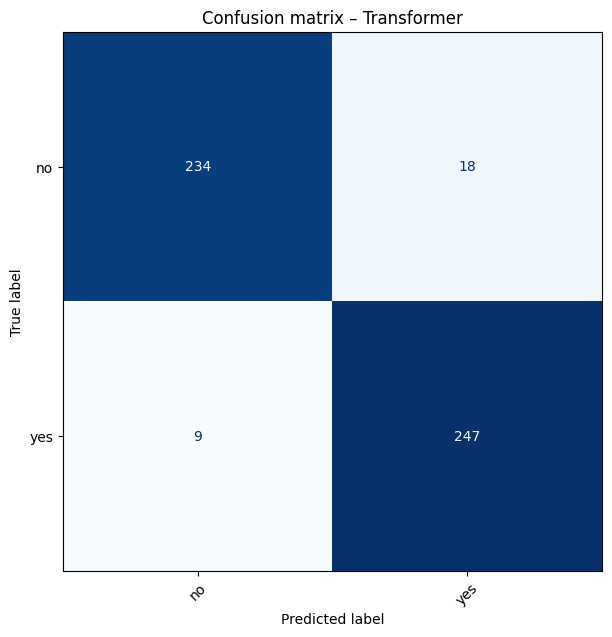

In [14]:
eval_model(device, tfm_model, test_loader, 'Transformer', id2label)